In [ ]:
# ✅ Colab 환경 고정 세팅 (항상 맨 위에 실행!)
!pip install -q numpy==1.26.4
!pip install -q scikit-surprise==1.1.3
!pip install -q optuna==3.6.1

import numpy as np, pandas as pd, optuna
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
print("✅ 환경 세팅 완료 (numpy 1.26.4 / scikit-surprise 1.1.3 / optuna 3.6.1)")


✅ 환경 세팅 완료 (numpy 1.26.4 / scikit-surprise 1.1.3 / optuna 3.6.1)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)  # 모든 컬럼 표시
pd.set_option("display.width", 2000)        # 한 줄에 표시할 폭 늘리기
pd.set_option("display.max_colwidth", None) # 문자열 잘림 방지

# **한글**

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] =False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

# **데이터 불러오기 및 전처리**

In [ ]:
from google.colab import drive
import pandas as pd


# 1. 구글 드라이브 마운트
drive.mount('/content/drive')

# 2. 데이터 불러오기
base_path = "/content/drive/MyDrive"

links = pd.read_csv(f"{base_path}/links.csv")
movies = pd.read_csv(f"{base_path}/movies.csv")
ratings = pd.read_csv(f"{base_path}/ratings.csv")
tags = pd.read_csv(f"{base_path}/tags.csv")



# 확인
#print(links.shape, movies.shape, ratings.shape, tags.shape)
#

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# timestamp → datetime 변환
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')

# 2020년 이후 데이터만 사용
cutoff_date = pd.Timestamp('2020-01-01')
ratings = ratings[ratings['timestamp'] >= cutoff_date].copy()
tags = tags[tags['timestamp'] >= cutoff_date].copy()

# ratings에 존재하는 영화만 필터링
movie_ids = ratings['movieId'].unique()
movies = movies[movies['movieId'].isin(movie_ids)].copy()
links = links[links['movieId'].isin(movie_ids)].copy()

# 마지막 날짜 확인
last_rating_date = ratings['timestamp'].max()
last_tag_date = tags['timestamp'].max()

# 확인 출력
print("ratings shape:", ratings.shape)
#print("tags shape:", tags.shape)
#print("movies shape:", movies.shape)
#print("links shape:", links.shape)
#print("ratings 마지막 날짜:", last_rating_date)
#print("tags 마지막 날짜:", last_tag_date)


ratings shape: (4635230, 4)


# **인기/숨겨진 보석 가중치 설정**

In [ ]:
# 인기 / 숨겨진 보석

# 상위 1% 기준
popular_threshold = ratings.groupby("movieId")["rating"].count().quantile(0.99)

movie_stats = ratings.groupby("movieId").agg(
    count=("rating", "count"),
    mean_rating=("rating", "mean")
).reset_index()

# 인기(Top 1%) 평균 평점
popular_avg = movie_stats.loc[movie_stats["count"] >= popular_threshold, "mean_rating"].mean()

# 인기 영화: 평점 수 상위 1%
movie_stats["is_popular"] = movie_stats["count"] >= popular_threshold

# 숨겨진 보석: 평점 수 상위 10%~1% 구간 & 인기 평균 평점보다 높음
movie_stats["is_hidden_gem"] = (
    (movie_stats["count"] >= movie_stats["count"].quantile(0.90)) &
    (movie_stats["count"] < popular_threshold) &
    (movie_stats["mean_rating"] > popular_avg)
)

# 가중치 → 튜닝 대상 (값 없음, Optuna에서 할당)
POPULAR_WEIGHT = None
HIDDEN_GEM_WEIGHT = None


# **장르별 분산 가중치 설정**

In [ ]:
# 장르별 분산

movies['genres_list'] = movies['genres'].str.split('|')
ratings_exploded = ratings.merge(movies[['movieId','genres_list']], on='movieId', how='left').explode('genres_list')

genre_variance = ratings_exploded.groupby("genres_list")["rating"].var().to_dict()

# 가중치 → 튜닝 대상
GENRE_VAR_WEIGHT = None


# **멀티 장르 가중치 설정**

In [ ]:
# 멀티/단일 장르

movies["is_multi_genre"] = movies["genres_list"].apply(lambda x: len(x) > 1)

# 가중치 → 튜닝 대상
MULTI_GENRE_WEIGHT = None
SINGLE_GENRE_WEIGHT = None


# **Optuna SVD**

In [ ]:
# 라이브러리
import numpy as np
import pandas as pd
import optuna
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# Surprise 데이터셋 & SVD 학습 (ratings 사용!)
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

svd_model = SVD(n_factors=100, n_epochs=30, random_state=42)
svd_model.fit(trainset)

# 아이템 임베딩(Q)
item_factors = np.array([svd_model.qi[i] for i in range(len(trainset.all_items()))])
item_index_to_id = {i: int(trainset.to_raw_iid(i)) for i in range(len(trainset.all_items()))}
item_id_to_index = {v: k for k, v in item_index_to_id.items()}

# 사용자 히스토리/전역 평균 (ratings 사용!)
global_mean = ratings['rating'].mean()

# trainset 기반 user_hist 생성 (데이터 누수 방지)
user_hist_train = {}

for uid_inner, iid_inner, r in trainset.all_ratings():
    # Surprise 내부 ID → 원래 ID로 변환
    uid = int(trainset.to_raw_uid(uid_inner))
    iid = int(trainset.to_raw_iid(iid_inner))

    if uid not in user_hist_train:
        user_hist_train[uid] = []
    user_hist_train[uid].append((iid, r))


# 장르 분산 보조 함수 (장르 분산 계산은 ratings_exploded 기반 유지)
def _adj_vf(mid):
    genres = movies.loc[movies["movieId"]==mid, "genres_list"].values
    if len(genres) and isinstance(genres[0], list) and len(genres[0]) > 0:
        vals = []
        for g in genres[0]:
            v = genre_variance.get(g, 1.0)
            if not np.isfinite(v):
                v = 1.0
            vals.append(1.0 / (1.0 + v))
        return float(np.mean(vals))
    return 0.0

# 평점용 보정(학습/평가용)
def _adjust_rating_score(score, mid, pop_w, gem_w, genre_w, multi_w, single_w):
    s = float(score)
    if movie_stats.loc[movie_stats["movieId"]==mid, "is_popular"].any():
        s += pop_w
    if movie_stats.loc[movie_stats["movieId"]==mid, "is_hidden_gem"].any():
        s += gem_w
    s += genre_w * _adj_vf(mid)
    is_multi = movies.loc[movies["movieId"]==mid, "is_multi_genre"].values
    if len(is_multi):
        s += (multi_w if bool(is_multi[0]) else single_w)
    return float(np.clip(s, 0.5, 5.0))

# 유사도용 보정(추천 랭킹용)
def _adjust_sim_score(sim, mid, pop_w, gem_w, genre_w, multi_w, single_w):
    base = max(0.0, float(sim))  # 음수 유사도 컷
    bonus = 0.0
    if movie_stats.loc[movie_stats["movieId"]==mid, "is_popular"].any():
        bonus += pop_w
    if movie_stats.loc[movie_stats["movieId"]==mid, "is_hidden_gem"].any():
        bonus += gem_w
    bonus += genre_w * _adj_vf(mid)
    is_multi = movies.loc[movies["movieId"]==mid, "is_multi_genre"].values
    if len(is_multi):
        bonus += (multi_w if bool(is_multi[0]) else single_w)
    return base + bonus

# 아이템 기반 예측치(사용자 히스토리 기반 k-NN 가중 평균)
def _predict_by_item_knn(uid, iid, top_m=30):
    hist = user_hist_train.get(uid, [])
    if not hist or iid not in item_id_to_index:
        return global_mean
    tgt_idx = item_id_to_index[iid]
    tgt_vec = item_factors[tgt_idx].reshape(1, -1)

    cand = [(mid, r) for (mid, r) in hist if (mid != iid and mid in item_id_to_index)]
    if not cand:
        return global_mean
    cand_indices = np.array([item_id_to_index[mid] for (mid, _) in cand])
    cand_ratings = np.array([r for (_, r) in cand], dtype=float)

    sims = cosine_similarity(tgt_vec, item_factors[cand_indices])[0]
    if len(sims) > top_m:
        top_idx = np.argpartition(-sims, top_m-1)[:top_m]
        sims = sims[top_idx]; cand_ratings = cand_ratings[top_idx]

    denom = np.sum(np.abs(sims)) + 1e-8
    return float(np.sum(sims * cand_ratings) / denom)

# Optuna: 가중치 최적화 (RMSE 최소화) — 5개 가중치 범위는 0~0.5
def objective(trial):
    pop_w   = trial.suggest_float('POPULAR_WEIGHT', 0.0, 0.5)
    gem_w   = trial.suggest_float('HIDDEN_GEM_WEIGHT', 0.0, 0.5)
    genre_w = trial.suggest_float('GENRE_VAR_WEIGHT', 0.0, 0.5)
    multi_w = trial.suggest_float('MULTI_GENRE_WEIGHT', 0.0, 0.5)
    single_w= trial.suggest_float('SINGLE_GENRE_WEIGHT', 0.0, 0.5)

    EVAL_SAMPLE = min(3000, len(testset))
    sq_err = []
    for (uid, iid, true_r) in testset[:EVAL_SAMPLE]:
        base = _predict_by_item_knn(uid, iid, top_m=30)
        adj = _adjust_rating_score(base, iid, pop_w, gem_w, genre_w, multi_w, single_w)
        sq_err.append((true_r - adj) ** 2)

    return float(np.sqrt(np.mean(sq_err))) if sq_err else 1e9

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=20, show_progress_bar=False)
best_params = study.best_params
print("Best params:", best_params)
print("Best RMSE:", study.best_value)

# 추천: 보정 후 재정렬 + 후보 풀(pool) 적용 + 통계 컬럼 포함 반환
# 추가 조건: 추천 대상은 평점 개수 상위 10% 이상만 허용
rec_count_threshold = movie_stats['count'].quantile(0.90)
count_lookup = movie_stats.set_index('movieId')['count'].to_dict()

def recommend_similar_movies(movie_ids, top_n=10, params=None, pool_size=500):
    if not isinstance(movie_ids, (list, tuple, set)):
        movie_ids = [int(movie_ids)]
    else:
        movie_ids = [int(mid) for mid in movie_ids]

    valid_ids = [mid for mid in movie_ids if mid in item_id_to_index]
    if not valid_ids:
        return pd.DataFrame(columns=['movieId','title','score','sim','mean_rating','count'])

    base_vecs = [item_factors[item_id_to_index[mid]] for mid in valid_ids]
    base_vec = np.mean(base_vecs, axis=0).reshape(1, -1)
    sims = cosine_similarity(base_vec, item_factors)[0]

    exclude = {item_id_to_index[mid] for mid in valid_ids}
    order = np.argsort(-sims)

    cand_idx = []
    for idx in order:
        if idx in exclude:
            continue
        cand_idx.append(idx)
        if len(cand_idx) >= pool_size:
            break

    rows = []
    for idx in cand_idx:
        mid = item_index_to_id[idx]
        if count_lookup.get(mid, 0) < rec_count_threshold:
            continue

        base = float(sims[idx])   # ✅ 보정 전 유사도
        score = base if not params else _adjust_sim_score(
            base, mid,
            params['POPULAR_WEIGHT'],
            params['HIDDEN_GEM_WEIGHT'],
            params['GENRE_VAR_WEIGHT'],
            params['MULTI_GENRE_WEIGHT'],
            params['SINGLE_GENRE_WEIGHT'],
        )
        rows.append((mid, score, base))

    if not rows:
        return pd.DataFrame(columns=['movieId','title','score','sim','mean_rating','count'])

    df = pd.DataFrame(rows, columns=['movieId','score','sim'])
    df = df.sort_values(['score','sim'], ascending=[False, False]).head(top_n)

    out = (
        df[['movieId','score','sim']]
        .merge(movies[['movieId','title']], on='movieId', how='left')
        .merge(movie_stats[['movieId','mean_rating','count']], on='movieId', how='left')
    )
    out['score'] = out['score'].astype(float).round(4)
    out['sim'] = out['sim'].astype(float).round(4)
    out['mean_rating'] = out['mean_rating'].astype(float).round(3)
    return out[['movieId','title','score','sim','mean_rating','count']]



[I 2025-09-29 05:59:56,387] A new study created in memory with name: no-name-ccd4eb96-c0e0-45c4-aada-59014328b7b3
[I 2025-09-29 06:00:10,351] Trial 0 finished with value: 1.0185548854452577 and parameters: {'POPULAR_WEIGHT': 0.18727005942368125, 'HIDDEN_GEM_WEIGHT': 0.4753571532049581, 'GENRE_VAR_WEIGHT': 0.36599697090570255, 'MULTI_GENRE_WEIGHT': 0.2993292420985183, 'SINGLE_GENRE_WEIGHT': 0.07800932022121826}. Best is trial 0 with value: 1.0185548854452577.
[I 2025-09-29 06:00:24,102] Trial 1 finished with value: 1.0102799052370282 and parameters: {'POPULAR_WEIGHT': 0.07799726016810132, 'HIDDEN_GEM_WEIGHT': 0.02904180608409973, 'GENRE_VAR_WEIGHT': 0.4330880728874676, 'MULTI_GENRE_WEIGHT': 0.3005575058716044, 'SINGLE_GENRE_WEIGHT': 0.35403628889802274}. Best is trial 1 with value: 1.0102799052370282.
[I 2025-09-29 06:00:37,727] Trial 2 finished with value: 0.9290415749974709 and parameters: {'POPULAR_WEIGHT': 0.010292247147901223, 'HIDDEN_GEM_WEIGHT': 0.48495492608099716, 'GENRE_VAR_WE

Best params: {'POPULAR_WEIGHT': 0.13974606901214937, 'HIDDEN_GEM_WEIGHT': 0.2816835124406072, 'GENRE_VAR_WEIGHT': 0.10325028984445817, 'MULTI_GENRE_WEIGHT': 0.06391216214132, 'SINGLE_GENRE_WEIGHT': 0.25360722514011735}
Best RMSE: 0.8913237544873592


# **test 출력**

In [ ]:
sample_movie = int(movies['movieId'].sample(1, random_state=42).iloc[0])
base_title = movies.loc[movies['movieId']==sample_movie, 'title'].values[0]
base_stats = movie_stats.loc[movie_stats['movieId']==sample_movie, ['mean_rating','count']].iloc[0]
print(f"기준 영화: {base_title} (movieId={sample_movie})")
print(f"- 기준 영화 평균 평점: {base_stats['mean_rating']:.3f}, 평점 개수: {int(base_stats['count'])}")

recs = recommend_similar_movies(sample_movie, top_n=10, params=best_params)
print(recs)


기준 영화: Here Awhile (2019) (movieId=218739)
- 기준 영화 평균 평점: 3.667, 평점 개수: 3
   movieId                                           title   score     sim  mean_rating  count
0   129514          George Carlin: It's Bad for Ya! (2008)  0.8511  0.2680        3.928    138
1   130970      George Carlin: Life Is Worth Losing (2005)  0.8464  0.2633        3.973    111
2     8528         Dodgeball: A True Underdog Story (2004)  0.6971  0.2559        3.383   2098
3    93838                     The Raid: Redemption (2011)  0.6763  0.2804        3.853   1104
4     3175                             Galaxy Quest (1999)  0.6351  0.2415        3.766   1410
5    54785                                Halloween (2007)  0.6067  0.3060        2.960    238
6     3869  Naked Gun 2 1/2: The Smell of Fear, The (1991)  0.6060  0.3046        3.632    509
7     2296                  Night at the Roxbury, A (1998)  0.5994  0.2980        2.905    221
8     1760                              Spice World (1997)  0.5977  0.2

In [ ]:
# Inception (2010)의 movieId 직접 지정
sample_movie = 79132

# 기준 영화 정보
base_title = movies.loc[movies['movieId']==sample_movie, 'title'].values[0]
base_stats = movie_stats.loc[movie_stats['movieId']==sample_movie, ['mean_rating','count']]

print(f"🎬 기준 영화: {base_title} (movieId={sample_movie})")
if not base_stats.empty:
    print(f"- 평균 평점: {base_stats['mean_rating'].values[0]:.3f}, "
          f"평점 개수: {int(base_stats['count'].values[0])}")

# 추천 결과
recs = recommend_similar_movies(sample_movie, top_n=10, params=best_params)
print(recs.to_string(index=False))


🎬 기준 영화: Inception (2010) (movieId=79132)
- 평균 평점: 4.163, 평점 개수: 15103
 movieId                         title  score    sim  mean_rating  count
  109487           Interstellar (2014) 0.9747 0.7232        4.198  12275
   74458         Shutter Island (2010) 0.8607 0.6054        4.055   8371
   48780          Prestige, The (2006) 0.8561 0.6016        4.184   7849
  287699            Oppenheimer (2023) 0.8497 0.2621        4.083   1152
  167832    The Invisible Guest (2016) 0.8287 0.2429        4.001    799
  208108            Dark Waters (2019) 0.8281 0.2406        3.901    930
   91529 Dark Knight Rises, The (2012) 0.8122 0.5595        3.940   8445
   58559       Dark Knight, The (2008) 0.7827 0.5289        4.194  13561
   33794          Batman Begins (2005) 0.7434 0.4904        3.882   8024
  164179                Arrival (2016) 0.7324 0.2910        4.066   8691


🎬 기준 영화: Inception (2010)


,movieId,title,score,sim,mean_rating,count
0,109487,Interstellar (2014),0.9747,0.7232,4.198,12275
1,74458,Shutter Island (2010),0.8607,0.6054,4.055,8371
2,48780,"Prestige, The (2006)",0.8561,0.6016,4.184,7849
3,287699,Oppenheimer (2023),0.8497,0.2621,4.083,1152
4,167832,The Invisible Guest (2016),0.8287,0.2429,4.001,799
5,208108,Dark Waters (2019),0.8281,0.2406,3.901,930
6,91529,"Dark Knight Rises, The (2012)",0.8122,0.5595,3.940,8445
7,58559,"Dark Knight, The (2008)",0.7827,0.5289,4.194,13561
8,33794,Batman Begins (2005),0.7434,0.4904,3.882,8024
9,164179,Arrival (2016),0.7324,0.2910,4.066,8691


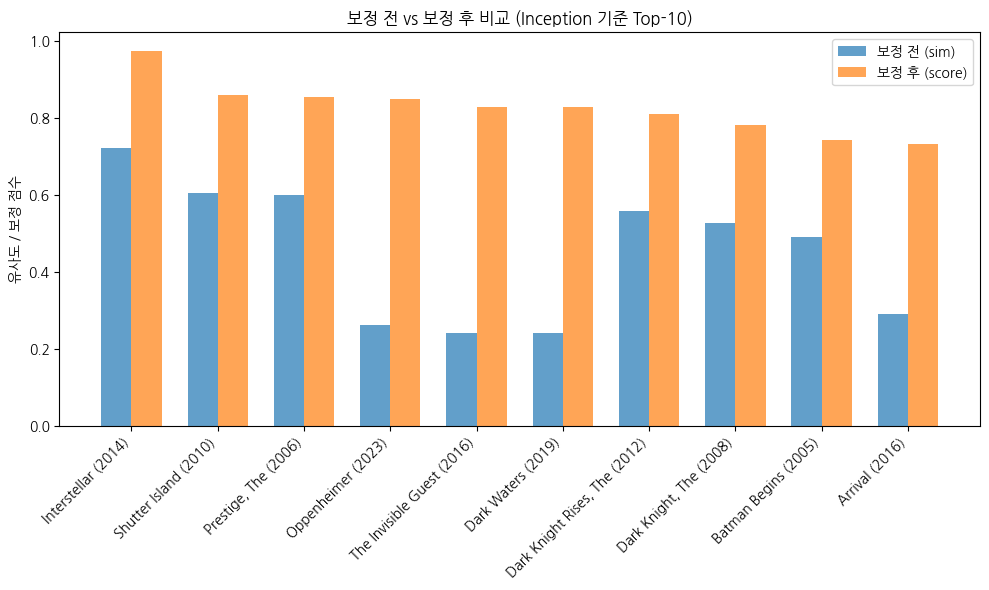

In [ ]:
# Inception movieId
sample_movie = int(movies.loc[movies['title']=="Inception (2010)", 'movieId'].iloc[0])
recs = recommend_similar_movies(sample_movie, top_n=10, params=best_params)

# 추천 결과 (보정 전 sim + 보정 후 score 포함)
recs = recommend_similar_movies(sample_movie, top_n=10, params=best_params)

print("🎬 기준 영화: Inception (2010)")
display(recs)

# 보정 전 vs 보정 후 점수 비교
plt.figure(figsize=(10,6))
bar_width = 0.35
x = np.arange(len(recs))

plt.bar(x - bar_width/2, recs["sim"], bar_width, label="보정 전 (sim)", alpha=0.7)
plt.bar(x + bar_width/2, recs["score"], bar_width, label="보정 후 (score)", alpha=0.7)

plt.xticks(x, recs["title"], rotation=45, ha="right")
plt.ylabel("유사도 / 보정 점수")
plt.title("보정 전 vs 보정 후 비교 (Inception 기준 Top-10)")
plt.legend()
plt.tight_layout()
plt.show()


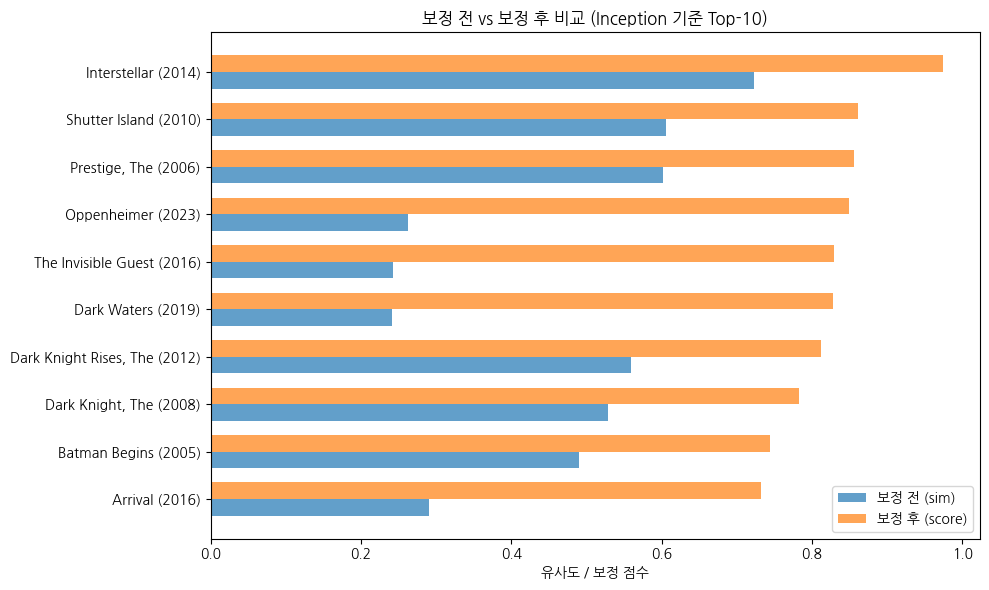

In [ ]:
# score 기준 내림차순 정렬
recs_sorted = recs.sort_values("score", ascending=True).reset_index(drop=True)

# 보정 전 vs 보정 후 점수 비교 (가로 막대)
plt.figure(figsize=(10,6))
bar_height = 0.35
y = np.arange(len(recs_sorted))

plt.barh(y - bar_height/2, recs_sorted["sim"], bar_height, label="보정 전 (sim)", alpha=0.7)
plt.barh(y + bar_height/2, recs_sorted["score"], bar_height, label="보정 후 (score)", alpha=0.7)

plt.yticks(y, recs_sorted["title"])
plt.xlabel("유사도 / 보정 점수")
plt.title("보정 전 vs 보정 후 비교 (Inception 기준 Top-10)")
plt.legend()
plt.tight_layout()
plt.show()
